Shape: (148670, 34)
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           

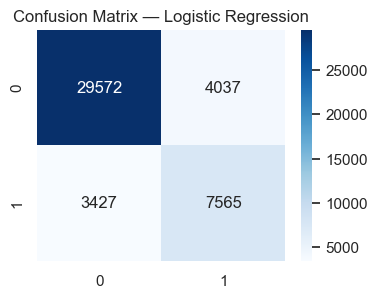


Training Model: Naive Bayes
Train Accuracy: 0.748
Test Accuracy: 0.8763
Training Time: 0.231146 sec
Prediction Time: 0.052149 sec


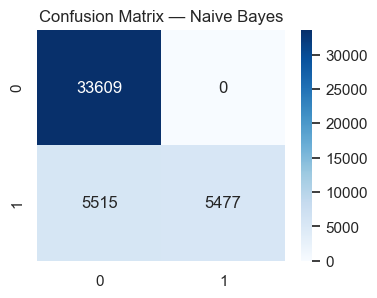


Training Model: SVM
Train Accuracy: 0.61
Test Accuracy: 0.4136
Training Time: 62.476895 sec
Prediction Time: 0.496029 sec


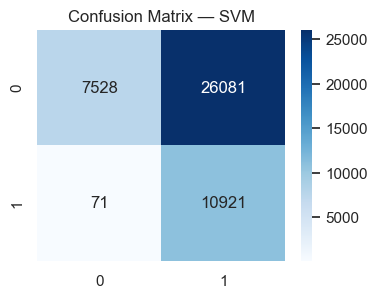


Training Model: Decision Tree
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 1.017403 sec
Prediction Time: 0.019816 sec


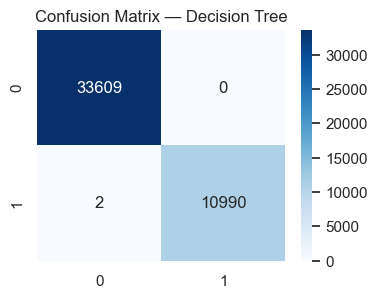


Training Model: Random Forest
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 68.081556 sec
Prediction Time: 1.650485 sec


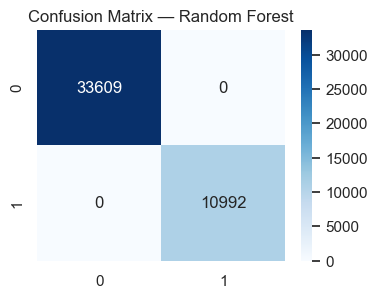


Training Model: XGBoost
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 2.236265 sec
Prediction Time: 0.061137 sec


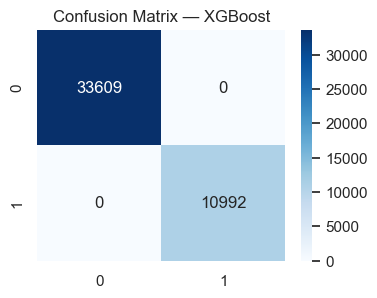


Training Model: KNN
Train Accuracy: 0.9607
Test Accuracy: 0.9023
Training Time: 0.200933 sec
Prediction Time: 20.305936 sec


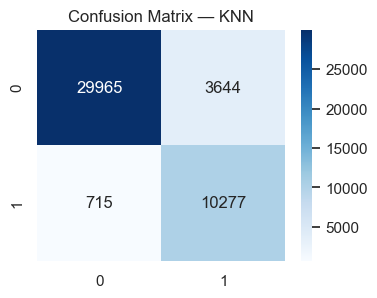


===== FINAL RESULTS =====

                 Model  Train Accuracy  Train Sensitivity  Train Specificity  \
0  Logistic Regression       81.440157          75.146005          87.734309   
1          Naive Bayes       74.795338          49.590676         100.000000   
2                  SVM       60.998189          99.621280          22.375099   
3        Decision Tree      100.000000         100.000000         100.000000   
4        Random Forest      100.000000         100.000000         100.000000   
5              XGBoost      100.000000         100.000000         100.000000   
6                  KNN       96.072531          99.795976          92.349086   

     Train F1   Train AUC  Test Accuracy  Test Sensitivity  Test Specificity  \
0   80.193506   88.753557      83.264949         68.822780         87.988336   
1   66.301828   99.999992      87.634806         49.827147        100.000000   
2   71.864853   63.531853      41.364543         99.354076         22.398762   
3  100.0000

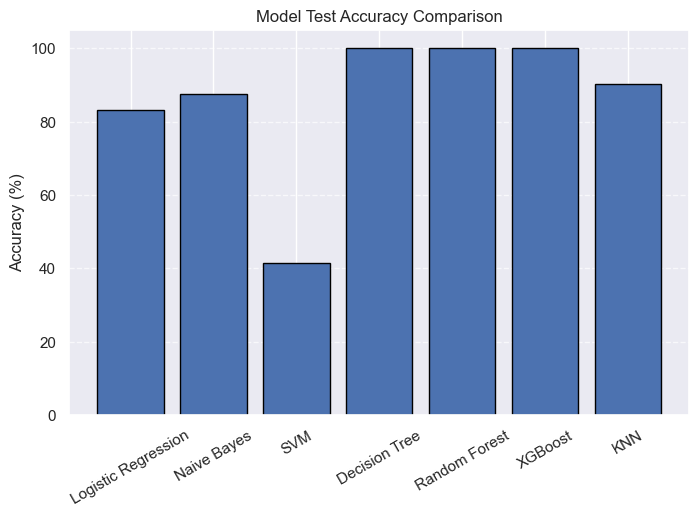

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

# SMOTE
from imblearn.over_sampling import SMOTE

# LOAD DATASET
df = pd.read_csv("data/Loan_default.csv")
print("Shape:", df.shape)
print(df.head())

TARGET = "Status"
print("\nTarget distribution before cleaning:")
print(df[TARGET].value_counts())

# HANDLE MISSING VALUES
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

if TARGET in cat_cols:
    cat_cols.remove(TARGET)

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after cleaning:")
print(df.isnull().sum())

# ENCODING
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("\nShape after encoding:", df.shape)

# FIX: X must be defined
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Fix column names for XGBoost
X.columns = (
    X.columns
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace('<', '', regex=False)
    .str.replace('>', '', regex=False)
    .str.replace('/', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nTrain/Test Split Done:")
print("Train:", X_train.shape, "| Test:", X_test.shape)

# SCALING
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# APPLY SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("\nBefore SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_sm.value_counts().to_dict())

# MODEL SETUP
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', max_iter=500, probability=True, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []
trained_models = {}

# ==========================================================
#                TRAINING + METRICS LOOP
# ==========================================================

for name, model in models.items():
    print("\n===============================")
    print(f"Training Model: {name}")
    print("===============================")

    # ------- TRAINING TIME -------
    start_train = time.time()
    model.fit(X_train_sm, y_train_sm)
    end_train = time.time()
    train_time = end_train - start_train

    trained_models[name] = model

    # ===========================
    # Train Predictions
    # ===========================
    y_train_pred = model.predict(X_train_sm)

    # Train Accuracy
    train_accuracy = accuracy_score(y_train_sm, y_train_pred)

    # TRAIN METRICS
    tn, fp, fn, tp = confusion_matrix(y_train_sm, y_train_pred).ravel()
    train_sensitivity = tp / (tp + fn)
    train_specificity = tn / (tn + fp)
    train_f1 = f1_score(y_train_sm, y_train_pred)

    try:
        train_proba = model.predict_proba(X_train_sm)[:, 1]
        train_auc = roc_auc_score(y_train_sm, train_proba)
    except:
        train_auc = None

    # ===========================
    # Test Predictions
    # ===========================
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    infer_time = end_pred - start_pred

    # Try probas
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except:
        y_proba = None
        auc = None

    # Test Metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)  # Sensitivity
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_specificity = tn / (tn + fp)

    # SAVE RESULTS
    results.append([
        name,

        # Train
        train_accuracy * 100,
        train_sensitivity * 100,
        train_specificity * 100,
        train_f1 * 100,
        train_auc * 100 if train_auc else None,

        # Test
        acc * 100,
        rec * 100,
        test_specificity * 100,
        f1 * 100,
        auc * 100 if auc else None,

        # Times
        train_time,
        infer_time
    ])

    print("Train Accuracy:", round(train_accuracy, 4))
    print("Test Accuracy:", round(acc, 4))
    print("Training Time:", round(train_time, 6), "sec")
    print("Prediction Time:", round(infer_time, 6), "sec")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

# ==========================================================
#                      RESULTS TABLE
# ==========================================================

results_df = pd.DataFrame(results, columns=[
    "Model",

    # Train
    "Train Accuracy", "Train Sensitivity", "Train Specificity",
    "Train F1", "Train AUC",

    # Test
    "Test Accuracy", "Test Sensitivity", "Test Specificity",
    "Test F1", "Test AUC",

    # Time
    "Training Time (sec)", "Prediction Time (sec)"
])

print("\n===== FINAL RESULTS =====\n")
print(results_df)

# ==========================================================
#                        BAR PLOT
# ==========================================================
plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["Test Accuracy"], edgecolor="black")
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


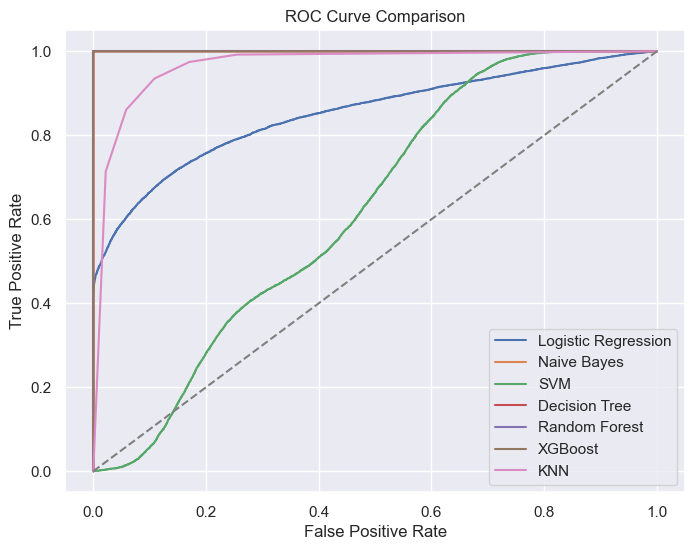

In [2]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

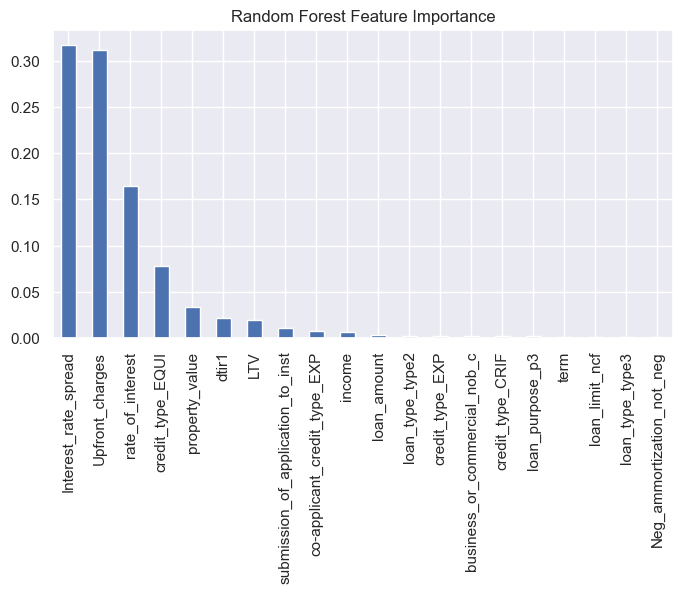

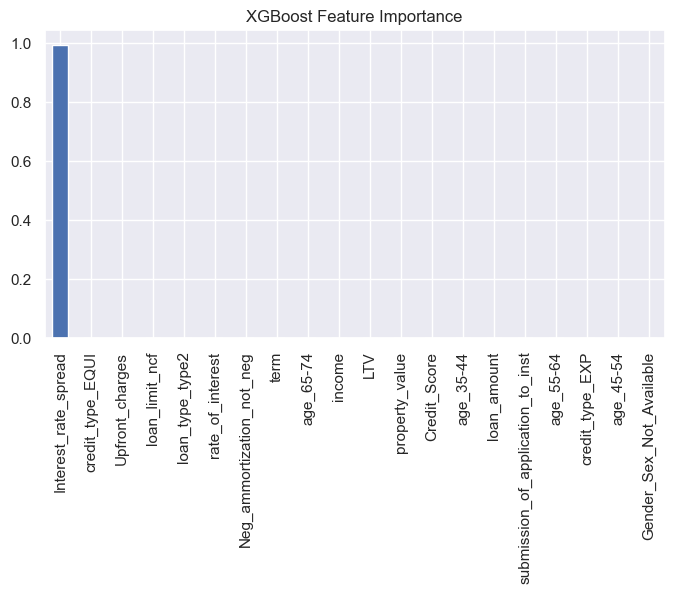

In [3]:
def plot_importances(model, title):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=X.columns)
        imp.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,4))
        plt.title(title)
        plt.show()

plot_importances(trained_models["Random Forest"], "Random Forest Feature Importance")
plot_importances(trained_models["XGBoost"], "XGBoost Feature Importance")